In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [2]:
#import the required libraries for loading the file
import json
import zipfile
import os

In [3]:
#Extract all the files from zip folder
from zipfile import ZipFile
with ZipFile('pdf_json.zip','r') as z:
  z.extractall('/content/files/')
z.close()

In [4]:
#load the file
files = os.listdir('/content/files/pdf_json/')
len(files)

56529

In [5]:
#function to extract text from the key body_text to create a corpus
def extract_body_text(filename):
    file = open(filename)
    paper_content = json.load(file)
    body_text =""
    if 'body_text' in paper_content: #look at the text that comes after the key 'body_text'
        for bt in paper_content['body_text']:
            body_text = body_text +bt['text']
    return (body_text+'\n').lower()

In [6]:
#import the required libraries for preprocessing
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
#load stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
#function to perform preprocessing
def data_preprocessing(text):
    text_low=text.lower() #converts the entire text to lower case
    text_cit=re.sub(r"[\[0-9]+]","",text_low) #removes the citations
    text_space = re.sub(' +', ' ', text_cit) #removes extra space
    text_cit=re.sub("[\x00-\x2F\x3A-\x40\x5B-\x60\x7B-\x7F]+"," ",text_space) #remove the punctuations
    text_num = re.sub(r'[0-9]+', '', text_cit) #removes numbers
    text_dash = re.sub('\-|\+','',text_num) #removes dashes
    text_tokens=word_tokenize(text_dash) #tokenize the words
    filtered_text=[w for w in text_tokens if not w in stop_words] #remove stopwords
    return " ".join(filtered_text)

In [9]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=5bb082c79a749f8933d7cbaea83969408323e505ace6a588e2163d82dc6f828b
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [10]:
#create a list of all the extracted english texts
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
corpus_list = []
for i in files:
    try:
        text = extract_body_text('/content/files/pdf_json/'+ i)
        if detect(text) == 'en': #look at only english texts
            corpus_list.append(data_preprocessing(text)) #preprocess each file
    except:
        pass

In [11]:
len(corpus_list)

54822

In [12]:
from collections import Counter
from nltk import ngrams

#Create a dictionary storing the count of each word in the corpus
vocab = Counter()
for text in corpus_list:
    tokens = [token for token in text.split(" ") if token != ""] #split each file into unigrams
    for word in tokens:
        vocab.update({word:1})

In [13]:
#select 14000 words from the vocabulary which have frequency greater than 50
vocab1 =[]
count=0
for word in vocab.keys():
  if vocab[word]>50:
    count+=1
    if count<14001:
      vocab1.append(word)

In [14]:
#dictionary to store the word and the corresponding index in the vocabulary
vocab_idx = {word: idx for idx, word in enumerate(vocab1)}

In [15]:
del files, text, vocab

In [16]:
import gc
gc.collect()

57

In [17]:
#create two zero matrices of size 14000*14000
import numpy as np
hal_l2r = np.zeros((len(vocab1),len(vocab1)))
hal_r2l = np.zeros((len(vocab1),len(vocab1)))

In [18]:
from collections import Counter
from nltk import ngrams

for text in corpus_list:
    tokens = [token for token in text.split(" ") if token != ""] #split each file into unigrams
    grams11 = ngrams(tokens,11) #look at the 11 grams
    ramp =[0,10,9,8,7,6,5,4,3,2,1]
    for index, grams in enumerate(grams11):
      reversed_grams = grams[::-1] #reverse the order for right to left
      if not None in grams:
        for idx, gram in enumerate(grams):
          try:
            hal_l2r[vocab_idx[grams[0]],vocab_idx[grams[idx]]]+=ramp[idx]
          except:
            pass
        for idx, gram in enumerate(reversed_grams):
          try:
            hal_r2l[vocab_idx[reversed_grams[0]],vocab_idx[reversed_grams[idx]]]+=ramp[idx]
          except:
            pass
    

In [19]:
#first part of the vector representation of a word
word_vec_l2r = [None for i in range(len(vocab1))]
for i in range(len(vocab1)):
  try:
    word_vec_l2r[i] = hal_l2r[i,:]/np.linalg.norm(hal_l2r[i,:]) #normalize the non zero values
  except:
    pass

In [20]:
#second part of the vector representation of a word
word_vec_r2l = [None for i in range(len(vocab1))]
for i in range(len(vocab1)):
  try:
    word_vec_r2l[i] = hal_r2l[i,:]/np.linalg.norm(hal_r2l[i,:]) #normalize the non zero values
  except:
    pass

In [21]:
#the vector representation of each word i is the ith row of hal_l2r 
#followed by ith row of hal_r2l
word_vec =[]
for i in range(len(vocab1)):
  word_vec.append(word_vec_l2r[i]+word_vec_r2l[i])

In [22]:
del hal_l2r, hal_r2l
gc.collect()

690

In [23]:
gc.collect()

82

In [30]:
#choosing 4 nouns
nouns = ['lungs','vietnam','oswald','germany']
#finding the top 10 similar words to each of the above nouns
id0 = vocab_idx[nouns[0]] #get the index of noun 1
vec0 = word_vec_l2r[id0]+word_vec_r2l[id0] #corresponding vector representation
dis0={} #dictionary storing the similar words and their distance
for i in range(len(vocab1)):
  dis0[vocab1[i]] = np.linalg.norm(word_vec[i]-vec0) #Euclidean norm
min_dist0 = sorted(dis0, key=dis0.get)[:10] #top 10 similar words

In [31]:
min_dist0

['lungs',
 'tissues',
 'lung',
 'organs',
 'suggesting',
 'tissue',
 'predominantly',
 'pathology',
 'infection',
 'contrast']

In [32]:
id1 = vocab_idx[nouns[1]]  #get the index of noun 2
vec1 = word_vec_l2r[id1]+word_vec_r2l[id1] #corresponding vector representation
dis1={} #dictionary storing the similar words and their distance
for i in range(len(vocab1)):
  dis1[vocab1[i]] = np.linalg.norm(word_vec[i]-vec1) #Euclidean norm
min_dist1 = sorted(dis1, key=dis1.get)[:10] #top 10 similar words

In [33]:
id2 = vocab_idx[nouns[2]] #get the index of noun 3
vec2 = word_vec_l2r[id2]+word_vec_r2l[id2] #corresponding vector representation
dis2={} #dictionary storing the similar words and their distance
for i in range(len(vocab1)):
  dis2[vocab1[i]] = np.linalg.norm(word_vec[i]-vec2) #Euclidean norm
min_dist2 = sorted(dis2, key=dis2.get)[:10] #top 10 similar words

In [34]:
id3 = vocab_idx[nouns[3]] #get the index of noun 4
vec3 = word_vec_l2r[id3]+word_vec_r2l[id3] #corresponding vector representation
dis3={} #dictionary storing the similar words and their distance
for i in range(len(vocab1)):
  dis3[vocab1[i]] = np.linalg.norm(word_vec[i]-vec3) #Euclidean norm
min_dist3 = sorted(dis3, key=dis3.get)[:10] #top 10 similar words

In [60]:
#table printing the similar words to each noun
print('Noun1\t\t\tNoun2\t\t\tNoun3\t\t\tNoun4')
print('---------\t\t--------\t\t----------\t\t--------')
print(f'\033[1m{min_dist0[0]}\t\t\t{min_dist1[0]}\t\t\t{min_dist2[0]}\t\t\t{min_dist3[0]}\033[0m')
# Iterate over the lists and print each row
for i in range(1,len(min_dist3)):
    print(f'{min_dist0[i]}\t\t\t{min_dist1[i]}\t\t\t{min_dist2[i]}\t\t\t{min_dist3[i]}')

Noun1			Noun2			Noun3			Noun4
---------		--------		----------		--------
lungs			vietnam			oswald			germany
tissues			indonesia			allen			switzerland
lung			thailand			clark			netherlands
organs			philippines			campbell			france
suggesting			malaysia			jones			belgium
tissue			singapore			butler			spain
predominantly			cambodia			myers			poland
pathology			taiwan			carter			sweden
infection			myanmar			cooper			usa
contrast			india			smith			denmark


In [42]:
vec0_similar = {}
for i in min_dist0:
  vec0_similar[i] = word_vec[vocab_idx[i]]
vec1_similar = {}
for i in min_dist1:
  vec1_similar[i] = word_vec[vocab_idx[i]]
vec2_similar = {}
for i in min_dist2:
  vec2_similar[i] = word_vec[vocab_idx[i]]
vec3_similar = {}
for i in min_dist3:
  vec3_similar[i] = word_vec[vocab_idx[i]]

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=2, n_components=2,init='pca',n_iter=2000, random_state=42)

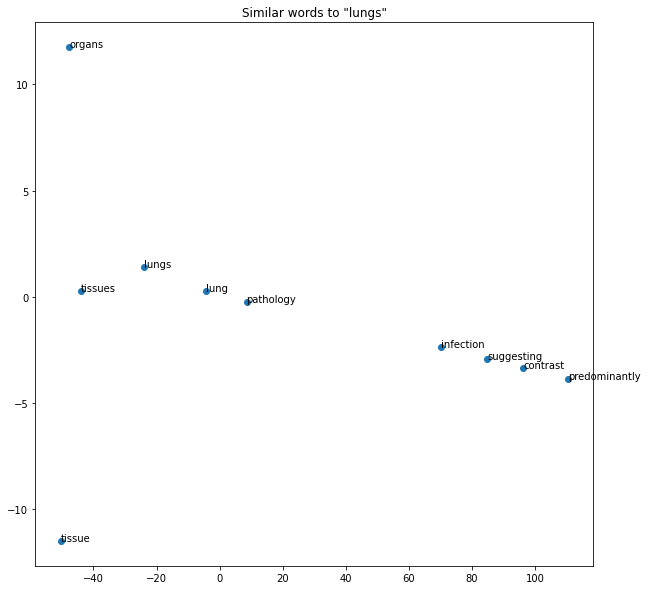

In [53]:
vec0_embed = tsne.fit_transform(np.asarray(list(vec0_similar.values())))
plt.figure(figsize=(10, 10))
plt.scatter(vec0_embed[:, 0], vec0_embed[:, 1])
for i, word in enumerate(min_dist0):
    plt.annotate(word, (vec0_embed[i, 0], vec0_embed[i, 1]))
plt.title(f'Similar words to "{nouns[0]}"')
plt.show()

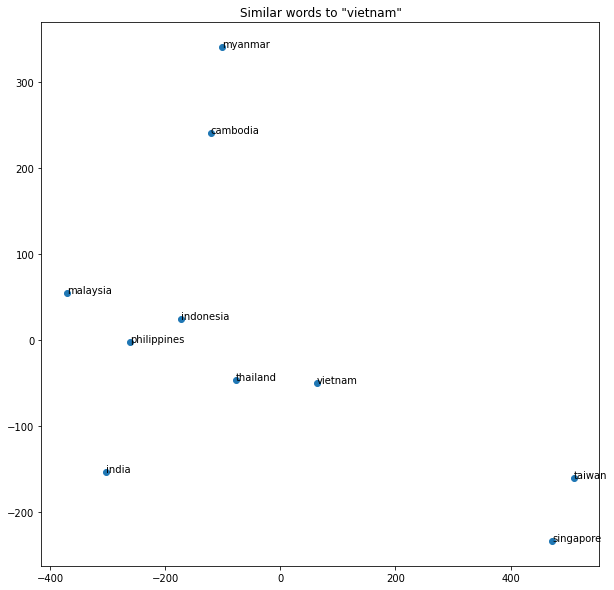

In [54]:
vec1_embed = tsne.fit_transform(np.asarray(list(vec1_similar.values())))
plt.figure(figsize=(10, 10))
plt.scatter(vec1_embed[:, 0], vec1_embed[:, 1])
for i, word in enumerate(min_dist1):
    plt.annotate(word, (vec1_embed[i, 0], vec1_embed[i, 1]))
plt.title(f'Similar words to "{nouns[1]}"')
plt.show()

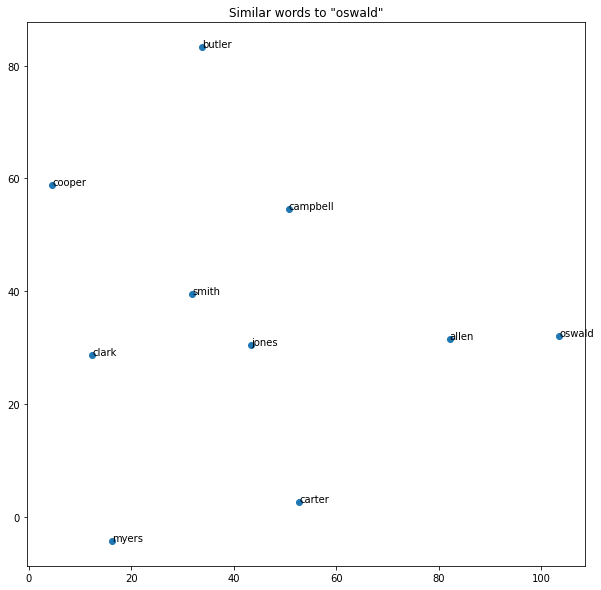

In [55]:
vec2_embed = tsne.fit_transform(np.asarray(list(vec2_similar.values())))
plt.figure(figsize=(10, 10))
plt.scatter(vec2_embed[:, 0], vec2_embed[:, 1])
for i, word in enumerate(min_dist2):
    plt.annotate(word, (vec2_embed[i, 0], vec2_embed[i, 1]))
plt.title(f'Similar words to "{nouns[2]}"')
plt.show()

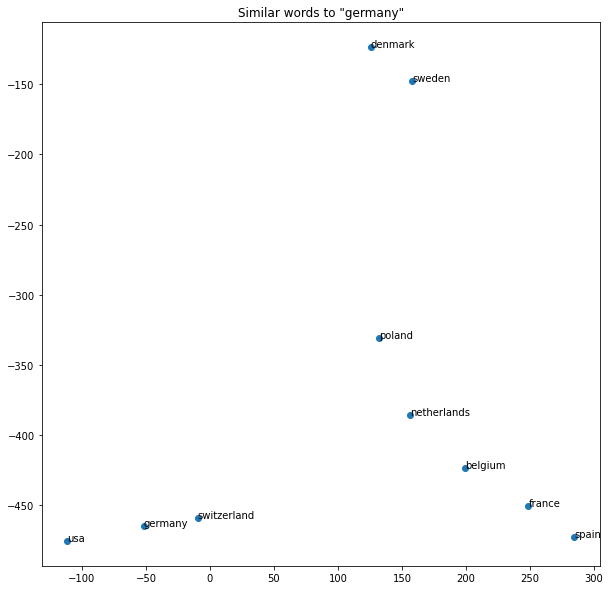

In [56]:
vec3_embed = tsne.fit_transform(np.asarray(list(vec3_similar.values())))
plt.figure(figsize=(10, 10))
plt.scatter(vec3_embed[:, 0], vec3_embed[:, 1])
for i, word in enumerate(min_dist3):
    plt.annotate(word, (vec3_embed[i, 0], vec3_embed[i, 1]))
plt.title(f'Similar words to "{nouns[3]}"')
plt.show()